In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention
import sys,os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50.json')
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()

(Index(['Topic', 'Title', 'article Id', 'Headline'], dtype='object'),
 Index(['Unnamed: 0', 'Topic', 'Article', 'Claim'], dtype='object'),
 522,
 522,
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'sentences', 'type',
        'urls'],
       dtype='object'))

In [4]:
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)

In [5]:
0.8*475

380.0

In [6]:
titles = sorted(df_hd_tp_cdc.Title.unique())
non_test_titles = list(set(titles)-set(test_titles))
val_titles = non_test_titles[380:]
train_titles = titles[:380]
len(train_titles),len(val_titles),len(test_titles)

(380, 95, 47)

In [7]:
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 10000

In [8]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [9]:
def datagen_cdc(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        hd = dataframe[dataframe.Title==idx]['Headline'].values[0].lower()
        hds.append(hd)
        ar_id = dataframe[dataframe.Title==idx]['article Id'].values[0]
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = article_vectors[ar_id]
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes=[],[],[],[]
            counter=0
            
def datagen_dnf(batchsize,dataframe):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        idx=np.random.choice(dataframe.id.nunique())
        hd = dataframe[dataframe.id==idx]['headline'].values[0]
        ar_id = dataframe[dataframe.id==idx]['id'].values[0]
        cl = dataframe[dataframe.id==idx]['sentences'].values[0]
        hds.append(hd)
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
        with open('evaluation_set/deepnofakes/cleaned/article_{0}.txt'.format(ar_id)) as f:
            article = f.readlines()
            
        article=''.join(article)
        # print(article)
        article = article.replace('[REF]','')
        doc = sentencizer(article)
        sentences = [sent.string.strip() for sent in doc.sents]
    
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = []
        for s in sentences:
            vectors.append(nlp(s.lower()).vector)
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes=[],[],[],[]
            counter=0
            

In [10]:
tdg = datagen_cdc(train_batchsize,df_hd_tp_cdc,mode='train')
vdg = datagen_cdc(val_batchsize,df_hd_tp_cdc,mode='val')
test_dg = datagen_cdc(test_batchsize,df_hd_tp_cdc,mode='test')

In [11]:
x,y = next(test_dg)

In [12]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

model params: 1460644


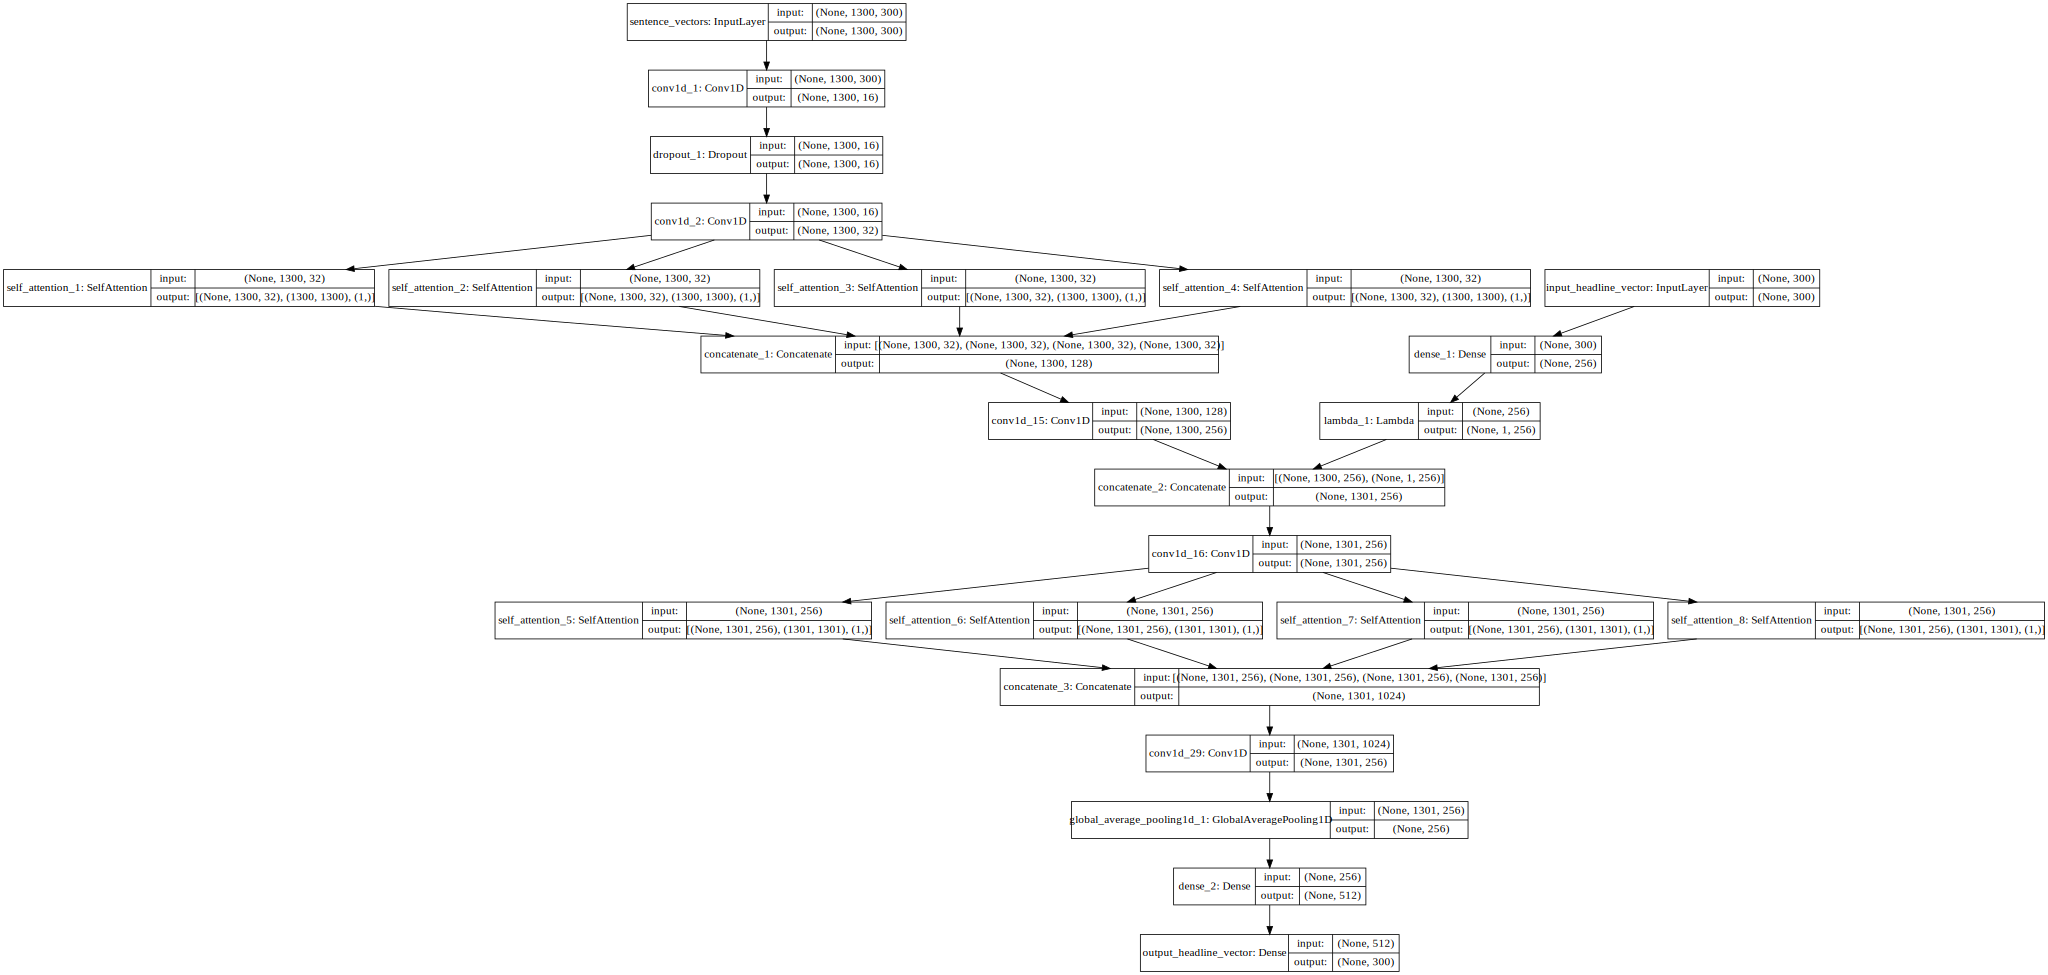

In [13]:
def build_model():
    inp_sentence_vectors = Input(shape=(1300, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]))(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline=Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    concat2 = Concatenate(axis=1)([conv3,headline])
    conv4 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat2)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = SelfAttention(int(conv4.shape[-1]))(conv4)
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = SelfAttention(int(conv4.shape[-1]))(conv4)
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = SelfAttention(int(conv4.shape[-1]))(conv4)
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = SelfAttention(int(conv4.shape[-1]))(conv4)  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    conv5 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat3)
    gap = GlobalAveragePooling1D()(conv5)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(),loss='mse')
# model.summary()
print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [14]:
dt = datetime.now()
mc = ModelCheckpoint('weights/cdc_sa_sent_hd_vector.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/cdc_sa_sent_hd_vector/{0}'.format(dt.timestamp()),write_graph=True)

In [ ]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/10000
4/4 [==============================] - 9s 2s/step - loss: 0.0462 - val_loss: 0.0459
Epoch 2/10000
4/4 [==============================] - 2s 377ms/step - loss: 0.0353 - val_loss: 0.0331
Epoch 3/10000
4/4 [==============================] - 4s 1s/step - loss: 0.0239 - val_loss: 0.0218
Epoch 4/10000
4/4 [==============================] - 3s 801ms/step - loss: 0.0200 - val_loss: 0.0176
Epoch 5/10000
4/4 [==============================] - 3s 671ms/step - loss: 0.0169 - val_loss: 0.0179
Epoch 6/10000
4/4 [==============================] - 4s 891ms/step - loss: 0.0175 - val_loss: 0.0162
Epoch 7/10000
4/4 [==============================] - 3s 655ms/step - loss: 0.0152 - val_loss: 0.0158
Epoch 8/10000
4/4 [==============================] - 3s 772ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 9/10000
4/4 [==============================] - 4s 883ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 10/10000
4/4 [==============================] - 3s 710ms/step - loss: 0.0164 - val_loss: 0.

In [ ]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [ ]:
# df_res = pd.DataFrame(hist.history)

In [ ]:
# df_res[['loss','val_loss']].plot()

In [ ]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [ ]:
model.load_weights('weights/cdc_sa_sent_hd_vector.hdf5')
model.evaluate_generator(test_dg,steps=1)

In [ ]:
x,y = next(test_dg)
pred = model.predict(x)

In [ ]:
x

In [ ]:
pred_classes = np.argmax(pred[0], axis=-1)

In [ ]:
pred_classes

In [ ]:
doc = nlp(str(x['headline'][0]))
doc.text

In [ ]:
ids = []
for token in doc:
    if token.has_vector:
#         print(token.norm)
        id = nlp.vocab.vectors.key2row[token.norm]
    else:
        id = None
    ids.append(id)

print([token for token in doc])
print(ids)

In [ ]:
words = []
for idx in pred_classes:
    if idx!=0:
        words.append(id_word_mapping[idx])
print(words)

In [ ]:
# df_key_value = pd.DataFrame(nlp.vocab.vectors.key2row,index=[0]).T.reset_index()
# df_key_value.columns = ['key','value']

In [ ]:
# df_key_value[df_key_value['value']==1282]['key'].values[0]

In [ ]:
# nlp.vocab.vectors.data[1282]

In [ ]:
# len(np.unique(list(nlp.vocab.vectors.key2row.keys()))),len(np.unique(list(nlp.vocab.vectors.key2row.values())))

In [ ]:
# vocab_dict = {}

In [ ]:
# counter = 0
# for s in nlp.vocab.strings:
#     print(s.
#     counter+=1
#     if counter==100:
#         break
    

In [ ]:


#     else:
#         print(len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values))

In [ ]:
# df_ar_cl_cdc.head()

In [ ]:
# sorted(df_hd_tp_cdc.Title.unique())

In [ ]:
# sorted(df_ar_cl_cdc.Article.unique())

In [ ]:
# for token1,token2 in zip(nlp('how are you hillary!'),nlp('How are You HILLARY!')):
#     print(token1.rank,token2.rank)